refer to
https://www.kaggle.com/code/gpreda/porto-seguro-exploratory-analysis-and-prediction/notebook

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

# Load data

In [7]:
trainset = pd.read_csv('../input/porto-seguro-safe-driver-prediction/train.csv')
testset = pd.read_csv('../input/porto-seguro-safe-driver-prediction/test.csv')

# Simple discription

- 유사한 데이터는 tagging을 통해 그룹으로 묶여있다.(ind, reg, car, calc)
- postfix를 통해 데이터 타입이 구분되어 있다.
    - bin: binary
    - cat: categorical
    - none: continuous or ordinal
- `-1` 은 `null` 을 의미한다.
- `target` 은 claim이 접수되었는지 여부를 의미한다.

In [8]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [9]:
print("Train dataset (rows, cols):",trainset.shape, "\nTest dataset (rows, cols):",testset.shape)

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows, cols): (892816, 58)


In [10]:
print("Columns in train and not in test dataset:",set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset: {'target'}


# Define class

## Introduction of metadata

In [11]:
class MetaTable():
    def __init__(self, df: pd.DataFrame=None):
        self.df = df
        self.meta=None
        
    #초기 meta 데이터 생성
    def _first_meta_table(self):
        if self.meta:
            print("Already exists")
            return self.meta
        
        print(f"dataset shape: {self.df.shape}")
        summary = pd.DataFrame(self.df.columns, columns=['name'])
        summary['dtype'] = self.df.dtypes.values
        summary['role'] = 'input'
        summary['type'] = None
        summary['keep'] = True
        summary['num_of_NaN'] = (self.df == -1).sum().values
        summary['num_of_unique_value'] = self.df.nunique().values
        summary['category'] = None
        summary = summary[['role', 'type', 'keep', 'dtype', 'num_of_NaN', 'num_of_unique_value', 'category', 'name']]
        summary.set_index('name', inplace=True)
        
        for col in self.df.columns:
            if 'bin' in col:
                summary.loc[col, 'type'] = 'binary'
            elif 'cat' in col:
                summary.loc[col, 'type'] = 'nominal'
            elif self.df[col].dtype == float:
                summary.loc[col, 'type'] = 'continuous'
            elif self.df[col].dtype == int:
                summary.loc[col, 'type'] = 'ordinal'
        
            if 'ind' in col:
                summary.loc[col, 'category'] = 'individual'
            elif 'reg' in col:
                summary.loc[col, 'category'] = 'registration'
            elif 'car' in col:
                summary.loc[col, 'category'] = 'car'
            elif 'calc' in col:
                summary.loc[col, 'category'] = 'calculated'
            
            if col == 'target':
                summary.loc[col, 'role'] = 'target'
                summary.loc[col, 'type'] = 'binary'
            if col == 'id':
                summary.loc[col, 'role'] = 'id'
                summary.loc[col, 'type'] = 'nominal'
                
        
        self.meta = summary
        return self.meta

In [12]:
class TabularDf(MetaTable):
    
    def __init__(self, df: pd.DataFrame):
        super().__init__()
        self.df = df
        self._first_meta_table()
        

In [13]:
df_table = TabularDf(trainset)

dataset shape: (595212, 59)


In [14]:
df_table.meta

,role,type,keep,dtype,num_of_NaN,num_of_unique_value,category
name,,,,,,,
id,id,nominal,True,int64,0,595212,None
target,target,binary,True,int64,0,2,None
ps_ind_01,input,ordinal,True,int64,0,8,individual
ps_ind_02_cat,input,nominal,True,int64,216,5,individual
ps_ind_03,input,ordinal,True,int64,0,12,individual
ps_ind_04_cat,input,nominal,True,int64,83,3,individual
ps_ind_05_cat,input,nominal,True,int64,5809,8,individual
ps_ind_06_bin,input,binary,True,int64,0,2,individual
ps_ind_07_bin,input,binary,True,int64,0,2,individual


meta 데이터를 이용하여 간편하게 데이터를 조작할 수 있다.

In [15]:
df_table.meta[(df_table.meta.type == 'nominal') & (df_table.meta.keep)].index

Index(['id', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='name')

In [16]:
pd.DataFrame({'count' : df_table.meta.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,registration,3


20개의 calculated features, 16개의 car features, 18개의 individual features, 3개의 registration features가 존재한다.

In [17]:
pd.DataFrame({'count' : df_table.meta.groupby(['role', 'type'])['role'].size()}).reset_index()

,role,type,count
0,id,nominal,1
1,input,binary,17
2,input,continuous,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


id와 target을 제외하고, 17개의 binary, 10개의 continuous, 14개의 nominal, 16개의 ordinal 특징들이 존재한다.

# Data analysis and statistics

## Define class

### Visualization

In [70]:
class TableDataViz():
    def __init__(self, df: pd.DataFrame=None):
        self.df = df
        self.colors=["#CD7F32", "#FFDF00"]
        
    # 특징 고윳값별 개수 시각화
    def countplot_sns(self, feature: str):
        plt.figure()
        fig, ax = plt.subplots(figsize=(20, 10))
        sns.countplot(x=feature, data=self.df, ax=ax)
        ax.set_title(f"{feature}_distribution", fontsize=30)
        self.set_label(ax, x_label="target", y_label="Count", fontsize=20)
        self._write_percent(ax=ax, total_size=len(self.df[feature]))
        plt.show()
        
        
    # 이진 데이터 타겟 비율 시각화
    def plot_target_ratio_by_features(self, features, num_rows, num_cols, size=None):
        
        if not size:
            size = (num_cols*9, num_rows*7)
        
        fig, ax = plt.subplots(num_rows, num_cols, figsize=size)
        
        for i in range(num_rows):
            for j in range(num_cols):
                sns.barplot(x=features[(i * num_cols) + j], y='target', data=self.df, ax=ax[i][j])
                
        plt.tight_layout()
        
    
    def plot_target_ratio_by_features_continuous(self, features, num_rows, num_cols, size=None, n_cut=5):
        
        if not size:
            size = (num_cols*9, num_rows*7)
        
        fig, ax = plt.subplots(num_rows, num_cols, figsize=size)
        
        for i in range(num_rows):
            for j in range(num_cols):
                self.df[f"{features[(i * num_cols) + j]}_cut"] = pd.cut(self.df[features[(i * num_cols) + j]], n_cut)
                sns.barplot(x=f"{features[(i * num_cols) + j]}_cut", y='target', data=self.df, ax=ax[i][j])
                
        plt.tight_layout()
    
    
    # msno를 이용한 결측치 시각화
    def plot_msno_bar(self, start_idx: int = None, end_idx: int = None, figsize=(13, 6)):
        if start_idx and end_idx:
            msno.bar(df=self.df.iloc[:, start_idx:end_idx])
        elif start_idx and not end_idx:
            msno.bar(df=self.df.iloc[:, start_idx:])
        elif not start_idx and end_idx:
            msno.bar(df=self.df.iloc[:, :end_idx])
        else:
            msno.bar(df=self.df.iloc[:, :])
            
            
    def plot_msno_matrix(self, start_idx: int = None, end_idx: int = None, figsize=(13, 6)):
        if start_idx and end_idx:
            msno.matrix(df=self.df.iloc[:, start_idx:end_idx])
        elif start_idx and not end_idx:
            msno.matrix(df=self.df.iloc[:, start_idx:])
        elif not start_idx and end_idx:
            msno.matrix(df=self.df.iloc[:, :end_idx])
        else:
            msno.matrix(df=self.df.iloc[:, :])
                   
    # pairplot
    def pairplot(self, features, hue, frac=None):
        if isinstance(features, str):
            features = [features]
        
        if frac:
            print(f"frac: {frac}")
            sample = self.df[features].sample(frac=frac)
        else:
            sample = self.df[features]
        sns.pairplot(sample, hue=hue, diag_kind='kde')
        plt.show()
        
    # correlation heatmap
    def corr_heatmap(self, features, drop_na=True):
        if len(features) <= 1:
            print("To get corr, need less than one params")
            return 
        
        # corr을 구하기 전 결측치 삭제 옵션
        if drop_na:
            df_copy = self.df.replace(-1, np.NaN).dropna()
            correlations = df_copy[features].corr()
        else:
            correlations = self.df[features].corr()
        # Create color map ranging between two colors
        cmap = sns.diverging_palette(50, 10, as_cmap=True)

        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                    square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
        
        plt.tight_layout()
        plt.show();
        
        
    def set_label(self, ax, x_label: str = '', y_label: str = '', fontsize=20):
        if x_label:
            ax.set_xlabel(x_label, fontsize=fontsize)
        if y_label:
            ax.set_ylabel(y_label, fontsize=fontsize)
        
    
    # 막대 그래프 위에 비율 표시
    def _write_percent(self, ax, total_size, fontsize=20):
        for patch in ax.patches:
            height = patch.get_height() # height (num of data)
            width = patch.get_width()
            left_coord = patch.get_x() # x coord of left side of geo
            percent = height/total_size*100
        
            # write percent info at (x, y)
            ax.text(left_coord + width/2.0, height + total_size*0.001,f"{percent:1.3f}", ha='center', fontsize=20)
    
    

In [71]:
class TabularDf(MetaTable, TableDataViz):
    
    def __init__(self, df: pd.DataFrame):
        super().__init__()
        self.df = df
        self._first_meta_table()
        
        
df_table = TabularDf(trainset)

dataset shape: (595212, 69)


## Target variable

<Figure size 432x288 with 0 Axes>

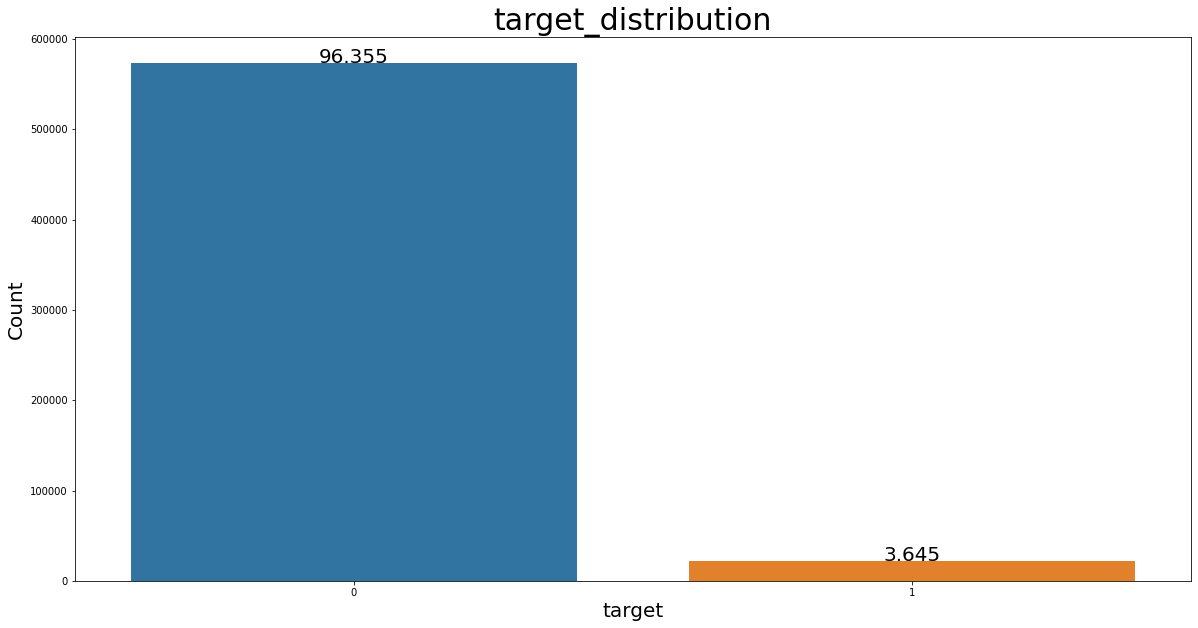

In [20]:
df_table.countplot_sns('target')

오직 3.64%의 데이터만이 1의 target 값을 갖는다.(매우 unbalanced한 데이터)
- 타겟 값이 불균형하기 때문에 비율이 작은 타겟 값 1을 잘 예측하는 것이 중요하다.
- 따라서 각 피쳐의 분포를 알아보기 보다, 각 피쳐의 고유 값별 타깃값 1의 비율을 통해 각 피쳐가 모델링에 필요한 정보인지 확인한다.
    - 고윳값 별로 타겟값의 비율이 똑같거나 통계적 유효성 떨어지면(편차가 너무 크는등), 해당 피처는 예측에 도움이 되지 않는다.

# Real(continuous) features

In [21]:
variable = df_table.meta[(df_table.meta.type == 'continuous') & (df_table.meta.keep)].index
df_table.df[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [22]:
df_table.df['ps_reg_01'].unique()

array([0.7, 0.8, 0. , 0.9, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])

In [23]:
df_table.df['ps_reg_02'].unique()

array([0.2, 0.4, 0. , 0.6, 1.8, 0.1, 0.7, 1.4, 0.9, 0.3, 0.5, 0.8, 1. ,
       1.3, 1.6, 1.5, 1.2, 1.1, 1.7])

In [24]:
(pow(trainset['ps_car_12']*10,2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [25]:
(pow(trainset['ps_car_15'],2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

__reg_variable__    
- ps_reg_03 특징은 널(-1)값을 갖는다.
- ps_reg_01, ps_reg_02 데이터는 0.1 단위의 소수이다.

__car_variable__    
- ps_car_12, ps_car_14 특징은 널(-1)값을 갖는다.
- ps_car_12는 자연수의 제곱근에 10을 나눈 값이며 ps_car_15는 자연수의 제곱근이다.

__calc_variaable__
- calc 특징들은 결측치가 존재하지 않는다.
- 최대 값이 0.9로 맞추어져 있다.
- 4분위 값이 모두 같으며 분포가 모두 비슷한 것을 확인할 수 있다.     
     
__overall__    
- 전체적으로 값의 범위가 크지 않고, 데이터 분포가 비슷한 특징들을 보아 사전에 데이터 가공이 이루어진 것을 알 수 있다.

frac: 0.05


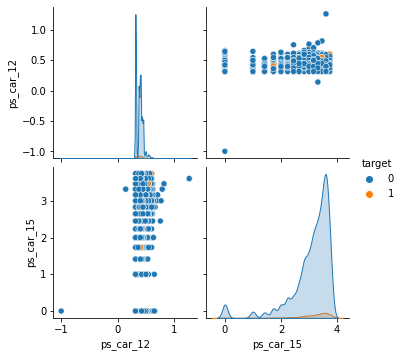

In [26]:
df_table.pairplot(features=['ps_car_12', 'ps_car_15', 'target'], hue='target', frac=0.05)

<Figure size 432x288 with 0 Axes>

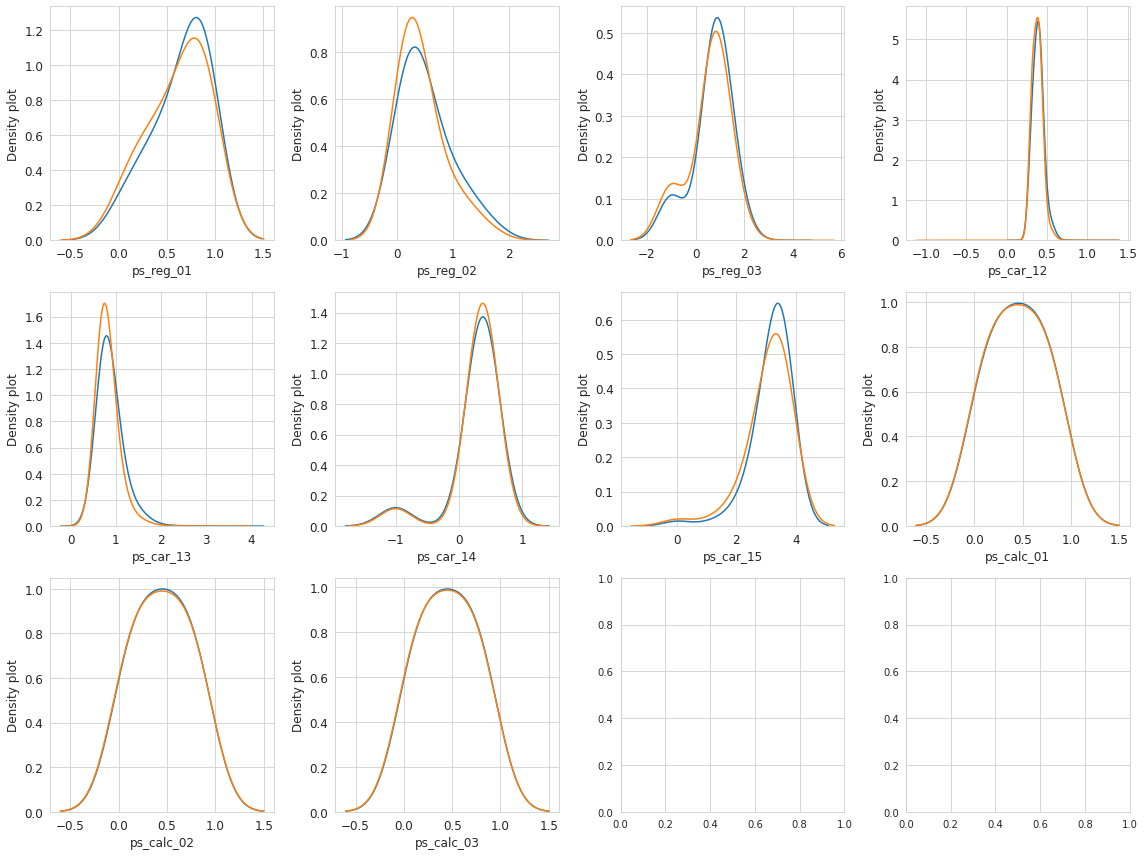

In [27]:
var = df_table.meta[(df_table.meta.type == 'continuous') & (df_table.meta.keep)].index
i = 0
t1 = df_table.df.loc[df_table.df['target'] != 0]
t0 = df_table.df.loc[df_table.df['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
    i += 1
    plt.subplot(3,4,i)
    sns.kdeplot(t1[feature], bw_method=0.7, label="target = 1")
    sns.kdeplot(t0[feature], bw_method=0.7, label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show();

ps_reg_02, ps_car_13, ps_car_15 shows the most different distributions between sets of values associated with target=0 and target=1. (??)

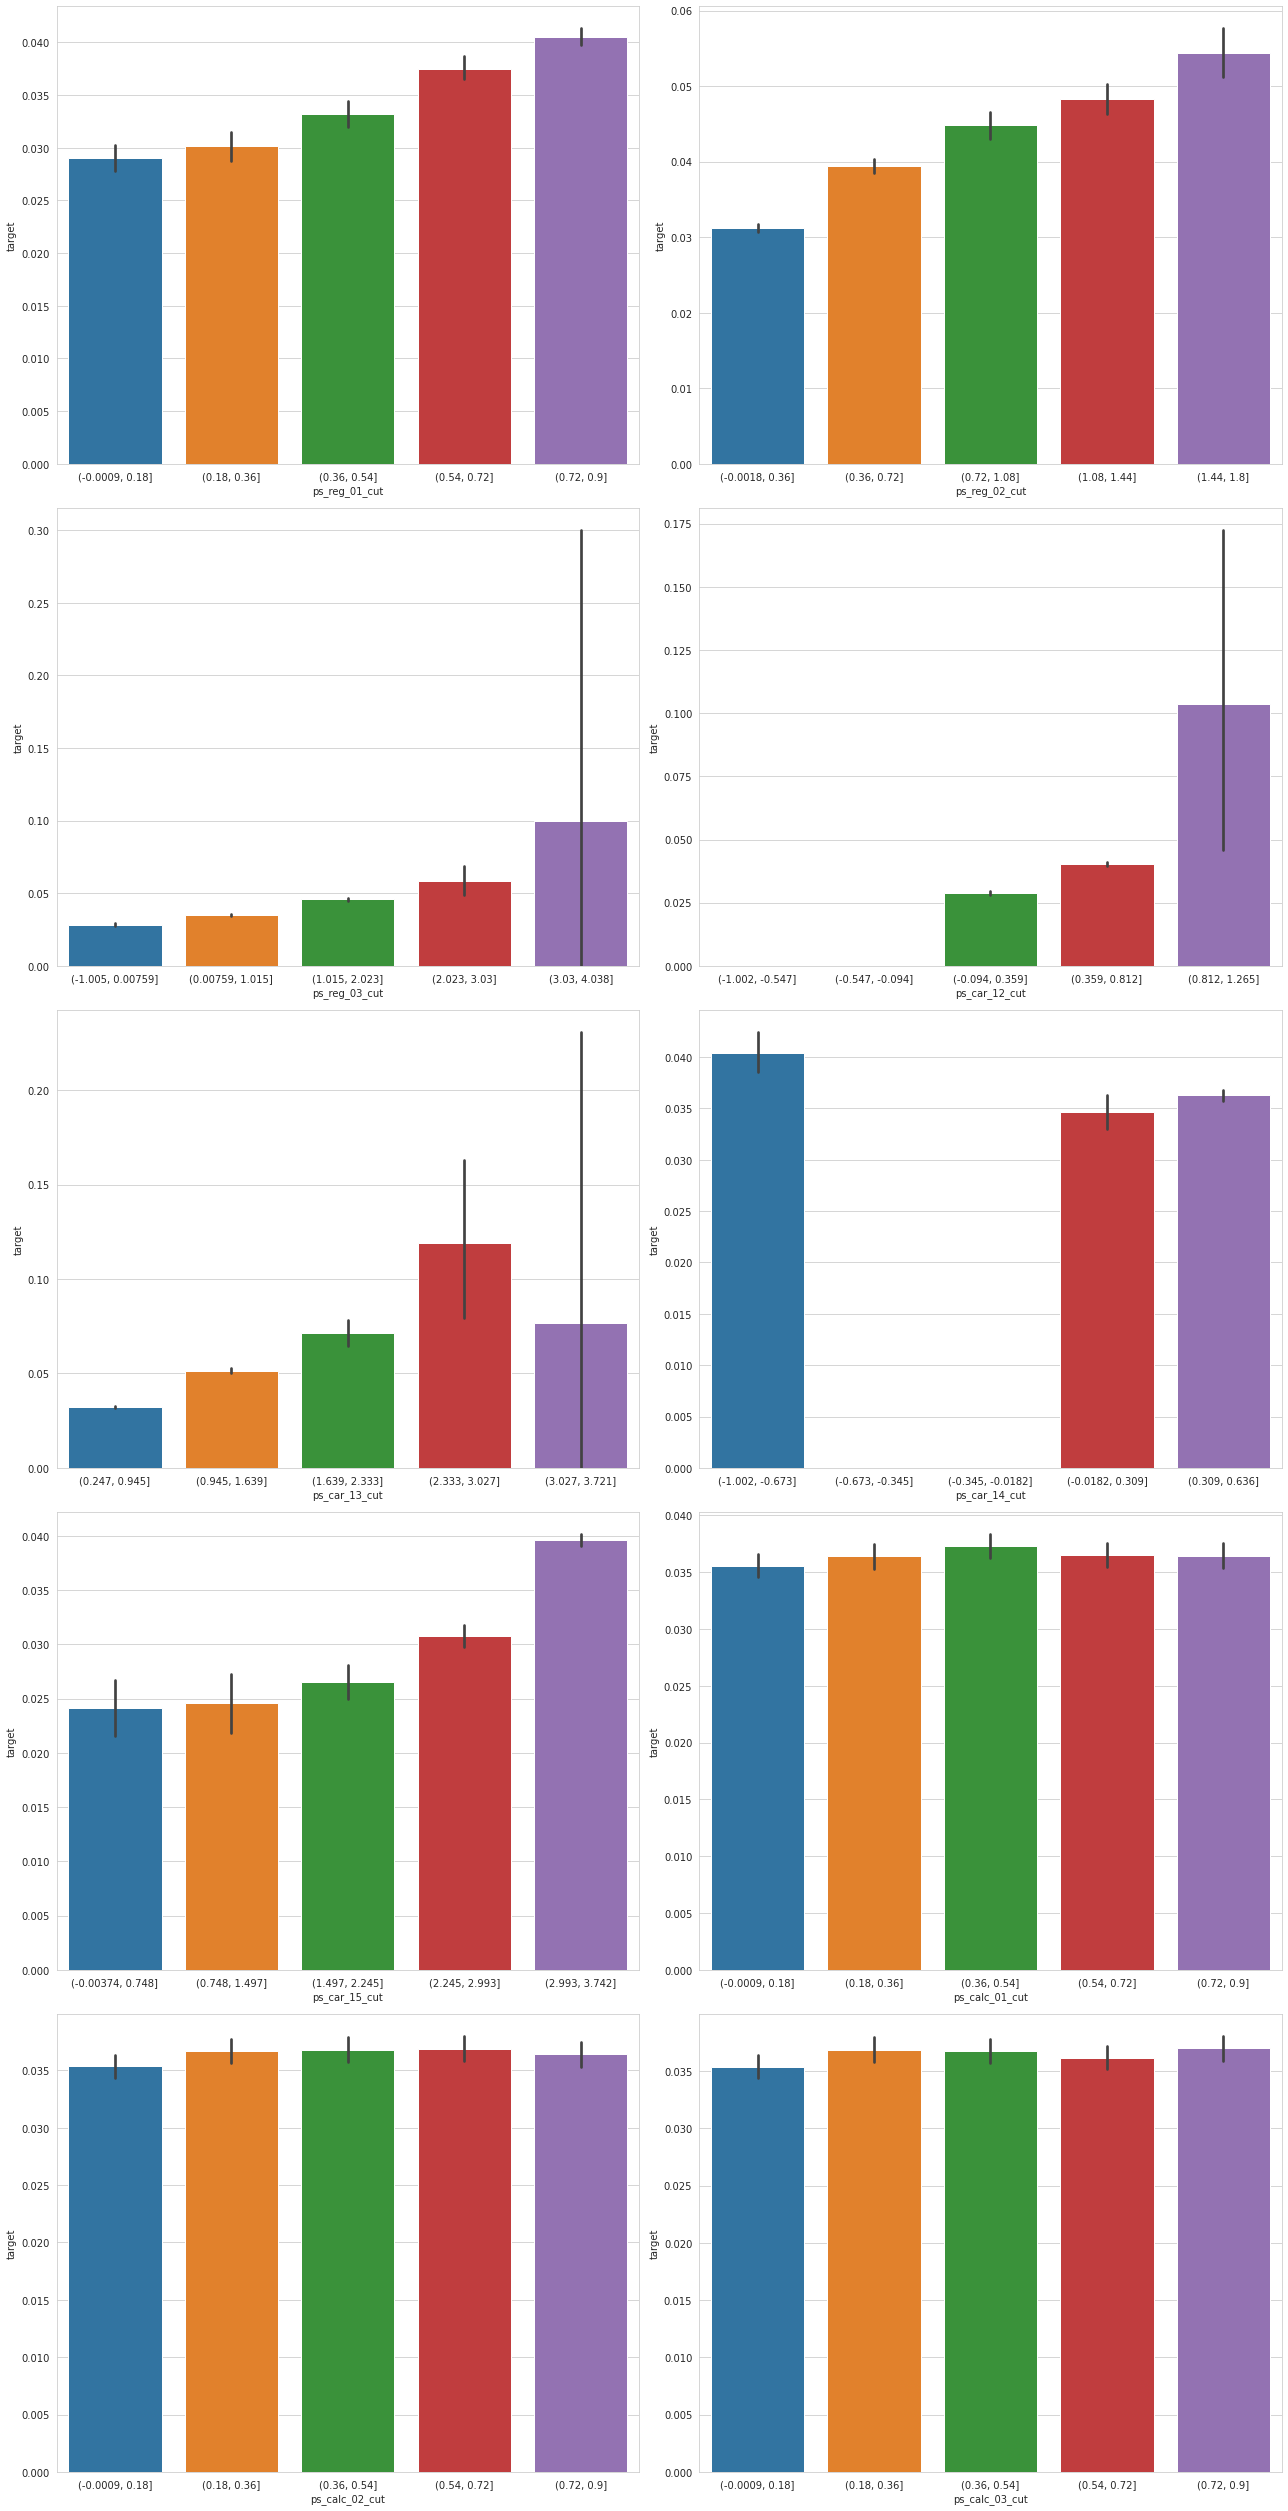

In [59]:
df_table.plot_target_ratio_by_features_continuous(df_table.meta[df_table.meta.type == 'continuous'].index, 5, 2, size=None, n_cut=5)

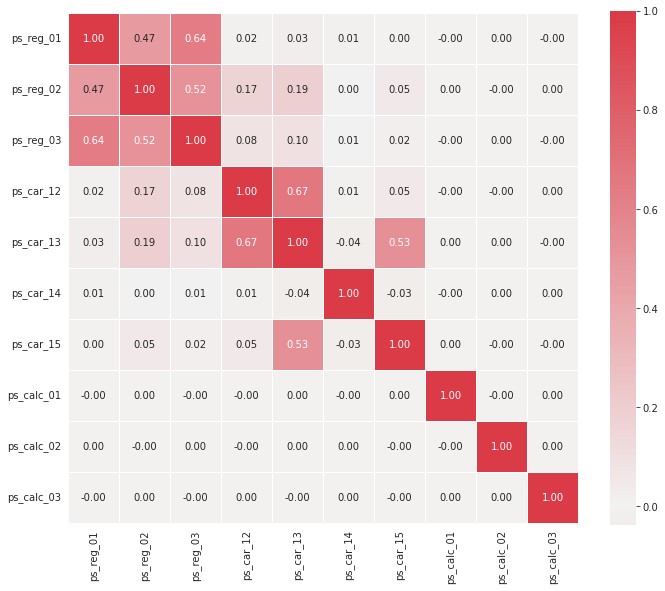

In [72]:
var = df_table.meta[(df_table.meta.type == 'continuous') & (df_table.meta.keep)].index
df_table.corr_heatmap(var, drop_na=False)

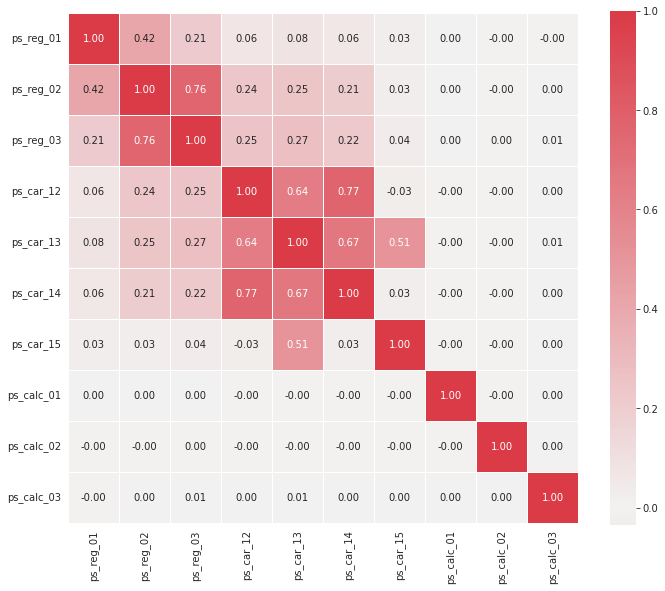

In [65]:
var = df_table.meta[(df_table.meta.type == 'continuous') & (df_table.meta.keep)].index
df_table.corr_heatmap(var)

correlation을 구하기 전 Null(-1) 값을 삭제하느냐 남기냐에 따라 corr의 결과가 달라진다.
-1 값을 제거 후 유의미한 상관관계를 갖는 인자들은 아래와 같다.
- ps_reg_02 and ps_reg_03(0.76)
- ps_reg_02 and ps_reg_02(0.42)
- `ps_car_12 and ps_car_14(0.77)`
- ps_car_12 and ps_car_13(0.64)
- ps_car_13 and ps_car_15(0.51)



-1 값을 유지한 상태에서 유의미한 상관관계를 갖는 인자들은 아래와 같다.
- ps_reg_01 and ps_reg_02 (0.47)
- `ps_reg_01 and ps_reg_03 (0.64)`
- ps_reg_02 and ps_reg_03 (0.52)
- ps_car_12 and ps_car_13 (0.67)
- ps_car_13 and ps_car_15 (0.53)

frac: 0.05


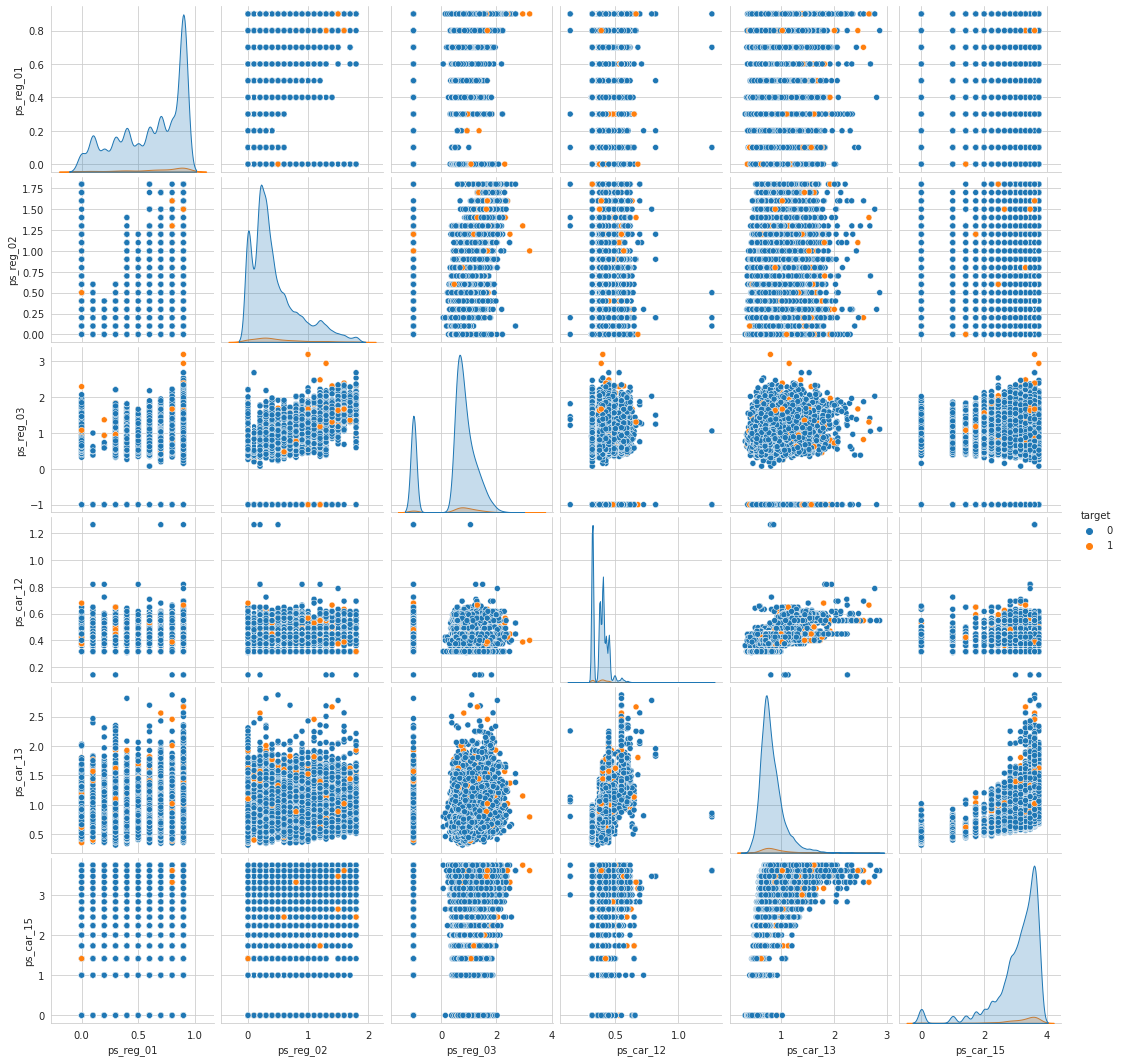

In [29]:
features = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
df_table.pairplot(features, hue='target', frac=0.05)

# Binary features

In [30]:
v = df_table.meta[(df_table.meta.type == 'binary') & (df_table.meta.keep)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


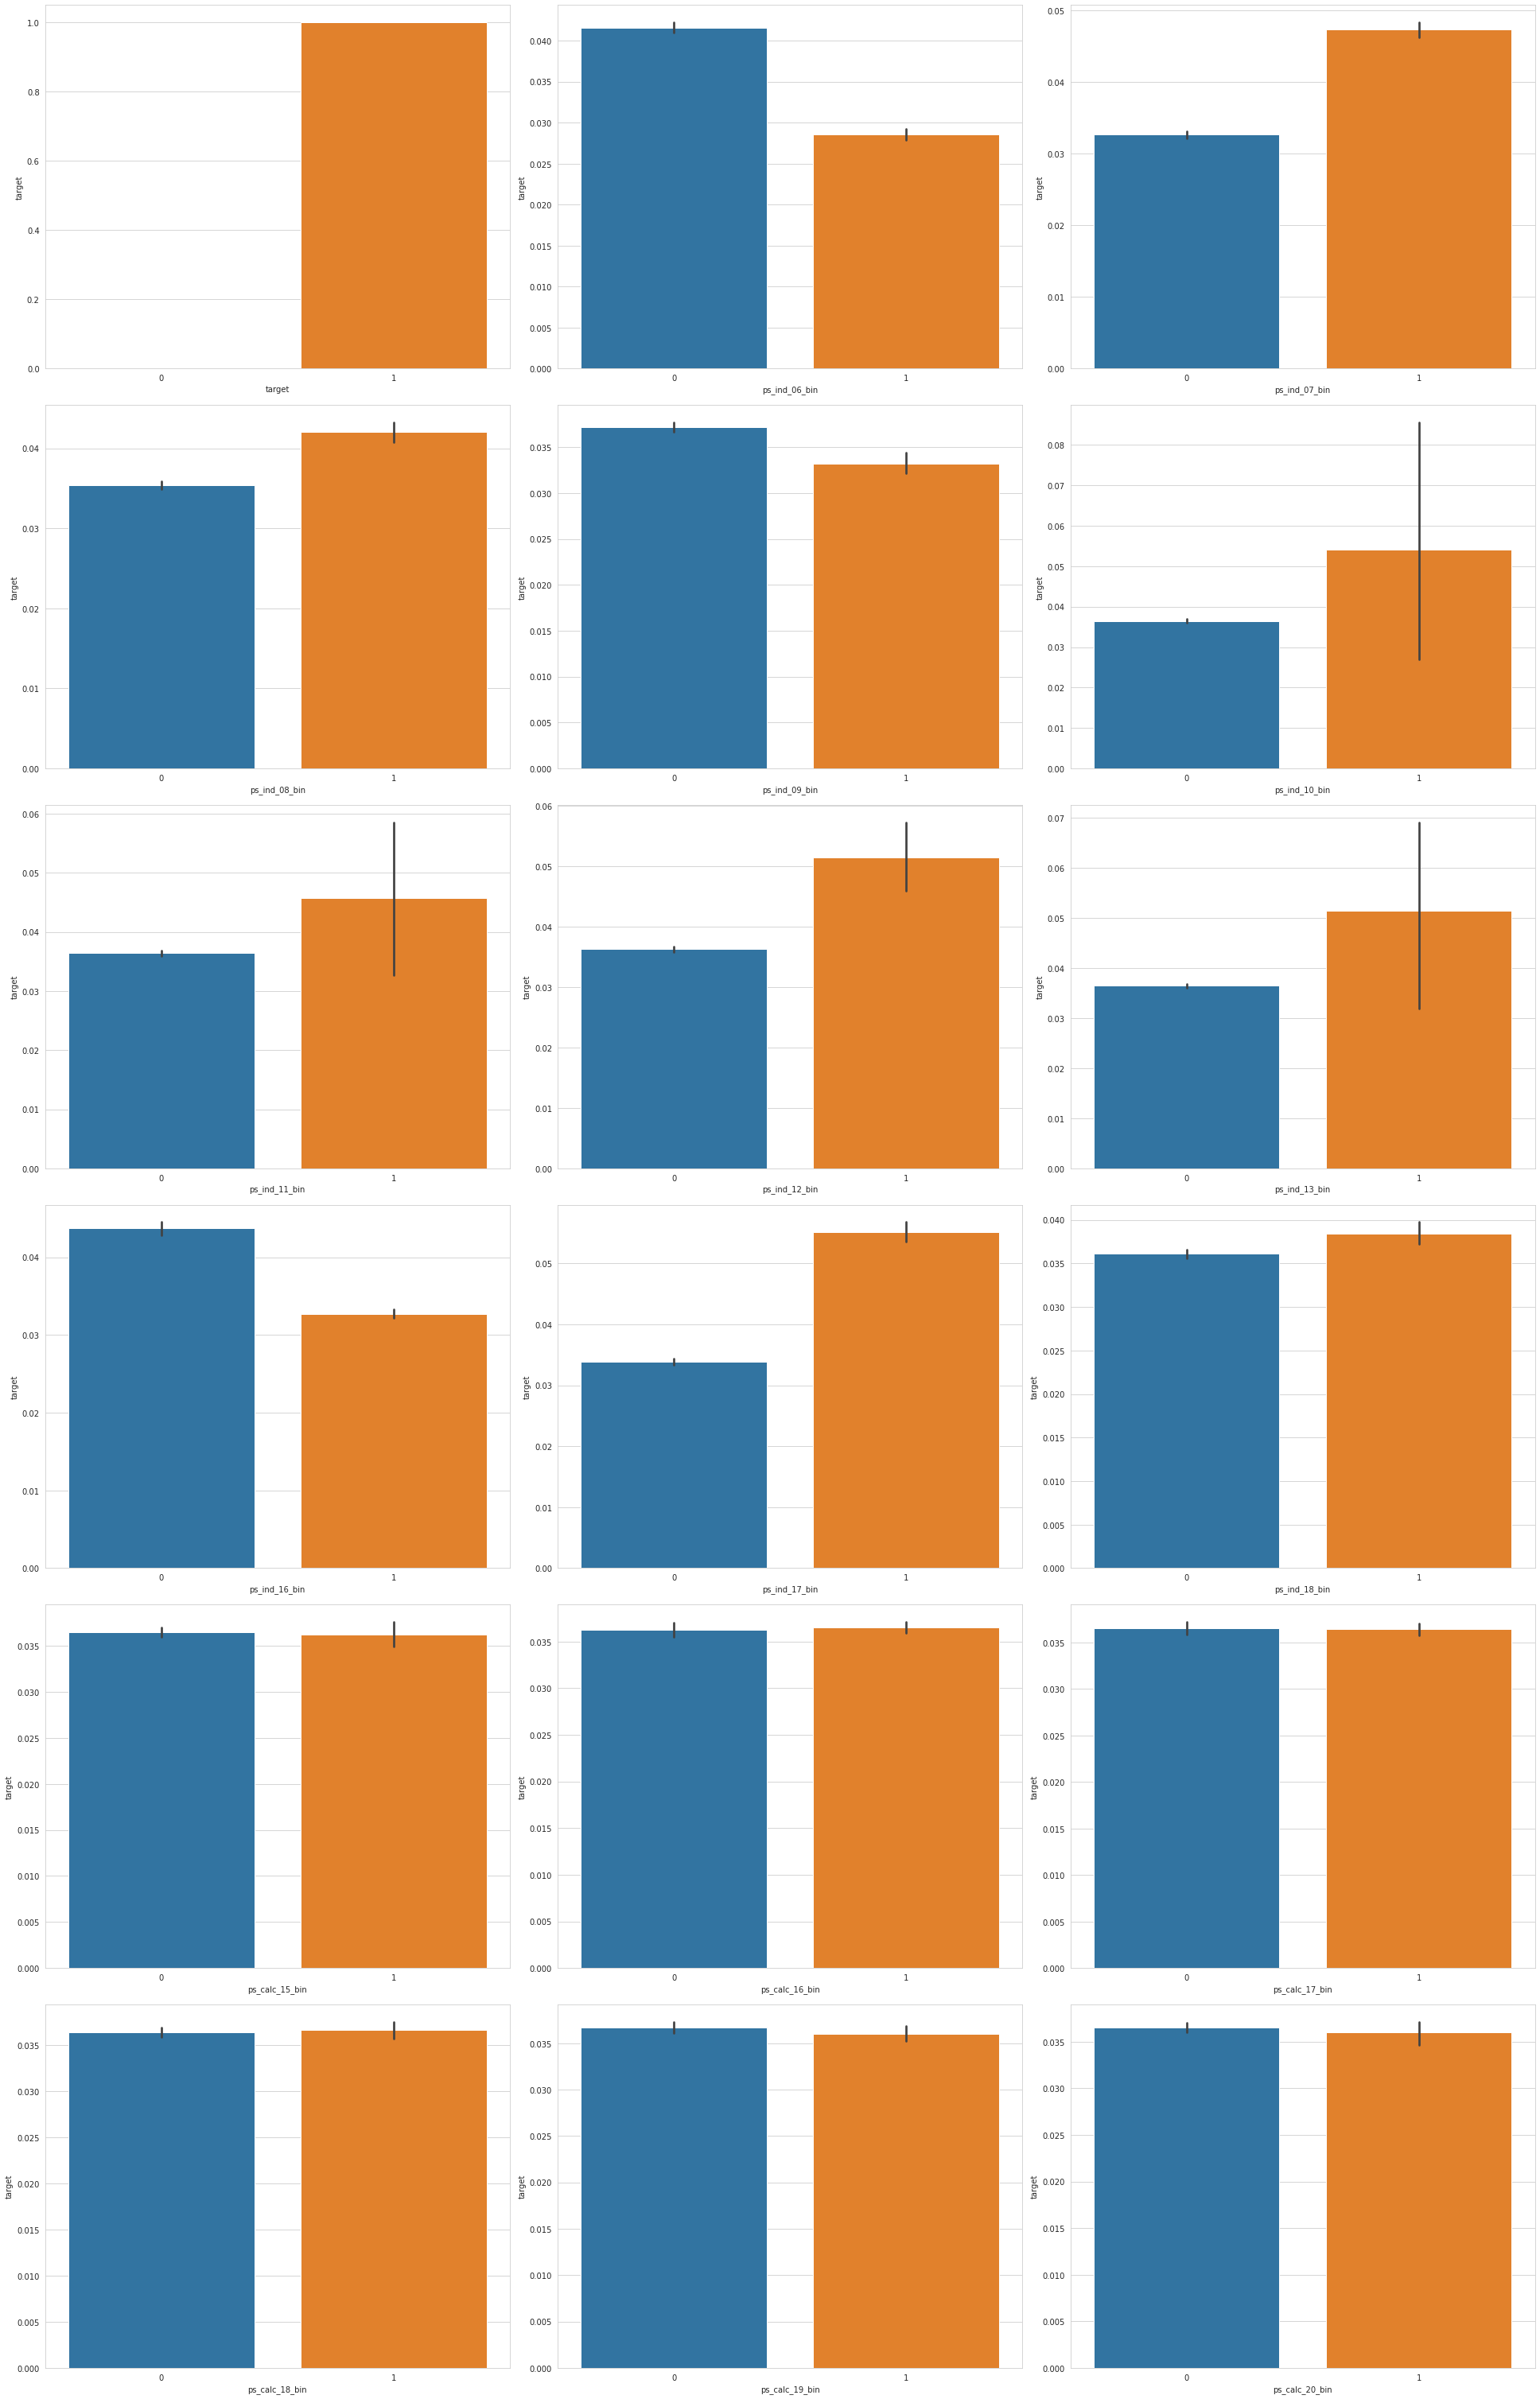

In [31]:
df_table.plot_target_ratio_by_features(df_table.meta[df_table.meta.type == 'binary'].index, 6, 3)

- ps_ind 10~13: 신뢰구간이 넓어서 통계적으로 유효성이 떨어지므로 제거한다.
- ps_calc_15~20: 고윳값별 타겟의 비율 차이가 크지 않으므로 제거한다.(모델링시 도움이 되지 않는다.)